# Thrust Period: Steps 1-10

**Purpose:** Explore the "hot" early training period where Adam's bias correction
dominates the dynamics. We decompose motion into:

1. **Gradient** |g|₂ — the raw training signal
2. **Adam term** |m̂/(√v̂+ε)|₂ — the normalized update direction
3. **Displacement** |ΔW|₂ — actual movement in weight space

**Key prediction:** At step 1, the Adam term should be ≈ √D for all tokens
due to bias correction cancellation.

**Data:** Crucible 2 trajectory (3,699 dead tokens, 64 dimensions)

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Paths
DATA_DIR = Path("../../tensors/Crucible-2")
TRAJECTORY_FILE = DATA_DIR / "crucible_2_trajectory.safetensors"

# Adam hyperparameters (from metadata)
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8
LR = 0.001
D = 64  # hidden dimension

print(f"√D = {np.sqrt(D):.4f}")

√D = 8.0000


In [25]:
# Load trajectory data
data = load_file(TRAJECTORY_FILE)

# W is stored as uint16 (bfloat16 bit patterns) - need to reinterpret
W_uint16 = data['W']  # [501, 3699, 64] - raw bits
W = W_uint16.view(torch.bfloat16).float()  # Convert: uint16 → bfloat16 → float32

m = data['m']      # [501, 3699, 64] - momentum buffer (already float32)
v = data['v']      # [501, 3699, 64] - variance buffer (already float32)
g = data['g']      # [500, 3699, 64] - gradients (already float32)

print(f"W shape: {W.shape} (converted from uint16 → bfloat16 → float32)")
print(f"m shape: {m.shape}")
print(f"v shape: {v.shape}")
print(f"g shape: {g.shape}")
print(f"\nNumber of dead tokens: {W.shape[1]}")
print(f"Hidden dimension: {W.shape[2]}")

W shape: torch.Size([501, 3699, 64]) (converted from uint16 → bfloat16 → float32)
m shape: torch.Size([501, 3699, 64])
v shape: torch.Size([501, 3699, 64])
g shape: torch.Size([500, 3699, 64])

Number of dead tokens: 3699
Hidden dimension: 64


In [26]:
def compute_adam_term(m_t, v_t, t, beta1=BETA1, beta2=BETA2, eps=EPSILON):
    """
    Compute the Adam term: m_hat / (sqrt(v_hat) + epsilon)
    
    This is the direction and relative magnitude of the update,
    before multiplication by learning rate.
    
    Args:
        m_t: momentum buffer at step t [n_tokens, dim]
        v_t: variance buffer at step t [n_tokens, dim]
        t: step number (1-indexed for bias correction)
        
    Returns:
        Adam term [n_tokens, dim]
    """
    # Bias correction factors
    bc1 = 1 - beta1 ** t
    bc2 = 1 - beta2 ** t
    
    # Bias-corrected estimates
    m_hat = m_t / bc1
    v_hat = v_t / bc2
    
    # The Adam term
    adam_term = m_hat / (torch.sqrt(v_hat) + eps)
    
    return adam_term

# Test: verify bias correction factors for first few steps
print("Bias correction factors:")
print(f"{'Step':>4} {'1-β₁ᵗ':>10} {'1-β₂ᵗ':>10} {'m correction':>12} {'v correction':>12}")
print("-" * 52)
for t in range(1, 11):
    bc1 = 1 - BETA1 ** t
    bc2 = 1 - BETA2 ** t
    print(f"{t:>4} {bc1:>10.6f} {bc2:>10.6f} {1/bc1:>12.2f} {1/bc2:>12.2f}")

Bias correction factors:
Step      1-β₁ᵗ      1-β₂ᵗ m correction v correction
----------------------------------------------------
   1   0.100000   0.001000        10.00      1000.00
   2   0.190000   0.001999         5.26       500.25
   3   0.271000   0.002997         3.69       333.67
   4   0.343900   0.003994         2.91       250.38
   5   0.409510   0.004990         2.44       200.40
   6   0.468559   0.005985         2.13       167.08
   7   0.521703   0.006979         1.92       143.29
   8   0.569533   0.007972         1.76       125.44
   9   0.612580   0.008964         1.63       111.56
  10   0.651322   0.009955         1.54       100.45


In [27]:
# Compute norms for steps 1-10
steps = range(1, 11)

grad_norms = []      # |g|₂
adam_norms = []      # |adam_term|₂
delta_W_norms = []   # |ΔW|₂

for t in steps:
    # Gradient norm (g is 0-indexed, so step t is g[t-1])
    g_t = g[t-1].float()  # [3699, 64]
    grad_norm = torch.linalg.norm(g_t, dim=1)  # [3699]
    grad_norms.append(grad_norm)
    
    # Adam term norm (m, v at step t)
    m_t = m[t].float()  # [3699, 64]
    v_t = v[t].float()  # [3699, 64]
    adam_term = compute_adam_term(m_t, v_t, t)
    adam_norm = torch.linalg.norm(adam_term, dim=1)  # [3699]
    adam_norms.append(adam_norm)
    
    # Weight displacement (W[t] - W[t-1])
    delta_W = W[t].float() - W[t-1].float()  # [3699, 64]
    delta_norm = torch.linalg.norm(delta_W, dim=1)  # [3699]
    delta_W_norms.append(delta_norm)

# Convert to arrays for easier manipulation
grad_norms = torch.stack(grad_norms).numpy()      # [10, 3699]
adam_norms = torch.stack(adam_norms).numpy()      # [10, 3699]
delta_W_norms = torch.stack(delta_W_norms).numpy()  # [10, 3699]

print(f"Computed norms for {len(steps)} steps, {grad_norms.shape[1]} tokens")

Computed norms for 10 steps, 3699 tokens


In [28]:
# Summary statistics
print("Step-by-step summary:")
print(f"{'Step':>4} {'|g|₂ mean':>12} {'|Adam|₂ mean':>14} {'|ΔW|₂ mean':>12} {'|Adam|₂ std':>12}")
print("-" * 60)
for i, t in enumerate(steps):
    print(f"{t:>4} {grad_norms[i].mean():>12.4f} {adam_norms[i].mean():>14.4f} "
          f"{delta_W_norms[i].mean():>12.6f} {adam_norms[i].std():>12.4f}")

print(f"\n√D = {np.sqrt(D):.4f} (expected Adam term at step 1)")
print(f"lr × √D = {LR * np.sqrt(D):.6f} (expected |ΔW| at step 1)")

Step-by-step summary:
Step    |g|₂ mean   |Adam|₂ mean   |ΔW|₂ mean  |Adam|₂ std
------------------------------------------------------------
   1       0.0006         8.0048     0.007902       0.0070
   2       0.0007         6.9458     0.006921       0.0131
   3       0.0007         6.8125     0.006819       0.0307
   4       0.0007         6.7963     0.006819       0.0385
   5       0.0007         6.8162     0.006821       0.0410
   6       0.0007         6.8949     0.006895       0.0476
   7       0.0007         7.0058     0.006985       0.0551
   8       0.0007         7.1168     0.007090       0.0613
   9       0.0007         7.2192     0.007194       0.0662
  10       0.0007         7.3035     0.007275       0.0701

√D = 8.0000 (expected Adam term at step 1)
lr × √D = 0.008000 (expected |ΔW| at step 1)


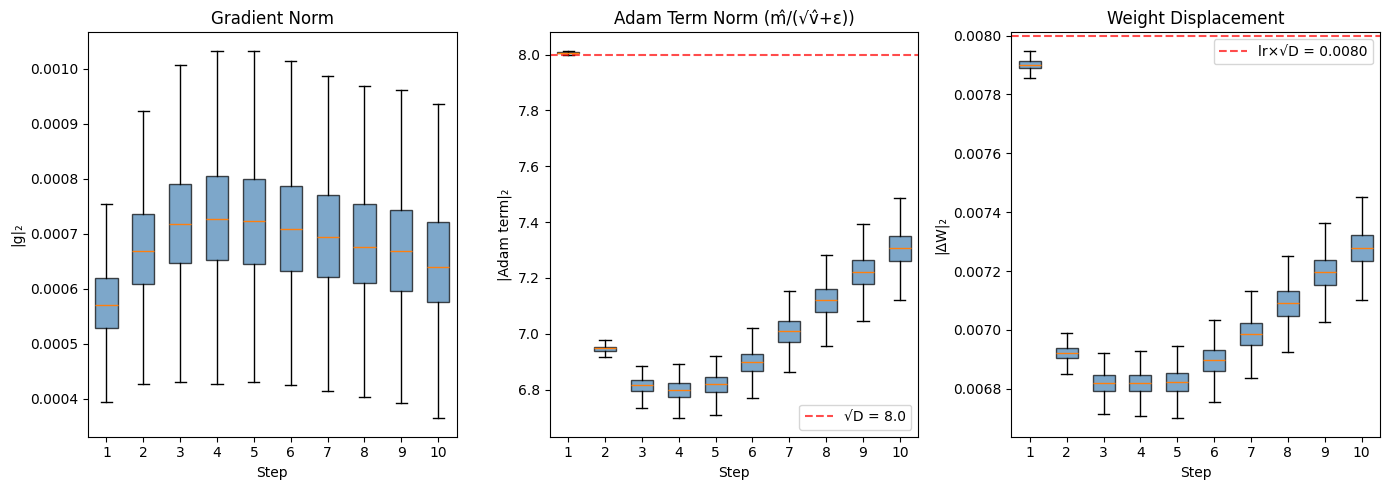

Saved: ../analysis/thrust_period_overview.png


In [29]:
# Visualization: three-panel plot showing distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Common styling
positions = list(steps)
color = 'steelblue'

# Panel 1: Gradient norms
ax = axes[0]
bp = ax.boxplot([grad_norms[i] for i in range(len(steps))], 
                positions=positions, widths=0.6,
                patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_xlabel('Step')
ax.set_ylabel('|g|₂')
ax.set_title('Gradient Norm')
ax.set_xticks(positions)

# Panel 2: Adam term norms
ax = axes[1]
bp = ax.boxplot([adam_norms[i] for i in range(len(steps))],
                positions=positions, widths=0.6,
                patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.axhline(y=np.sqrt(D), color='red', linestyle='--', alpha=0.7, label=f'√D = {np.sqrt(D):.1f}')
ax.set_xlabel('Step')
ax.set_ylabel('|Adam term|₂')
ax.set_title('Adam Term Norm (m̂/(√v̂+ε))')
ax.set_xticks(positions)
ax.legend()

# Panel 3: Displacement norms
ax = axes[2]
bp = ax.boxplot([delta_W_norms[i] for i in range(len(steps))],
                positions=positions, widths=0.6,
                patch_artist=True, showfliers=False)
for patch in bp['boxes']:
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.axhline(y=LR * np.sqrt(D), color='red', linestyle='--', alpha=0.7, 
           label=f'lr×√D = {LR * np.sqrt(D):.4f}')
ax.set_xlabel('Step')
ax.set_ylabel('|ΔW|₂')
ax.set_title('Weight Displacement')
ax.set_xticks(positions)
ax.legend()

plt.tight_layout()
plt.savefig('../analysis/thrust_period_overview.png', dpi=200, bbox_inches='tight')
plt.show()

print("Saved: ../analysis/thrust_period_overview.png")

In [30]:
# Deep dive on step 1: verify the cancellation
print("=" * 60)
print("STEP 1 DEEP DIVE: The Cancellation")
print("=" * 60)

# At step 1, Adam term should be exactly sign(g) (assuming |g| >> ε)
# So |Adam term|₂ should be √D for all tokens

step1_adam = adam_norms[0]  # [3699]
step1_grad = grad_norms[0]  # [3699]
step1_delta = delta_W_norms[0]  # [3699]

print(f"\nAdam term |m̂/(√v̂+ε)|₂ at step 1:")
print(f"  Mean:   {step1_adam.mean():.6f}")
print(f"  Std:    {step1_adam.std():.6f}")
print(f"  Min:    {step1_adam.min():.6f}")
print(f"  Max:    {step1_adam.max():.6f}")
print(f"  Expected (√D): {np.sqrt(D):.6f}")

print(f"\nDisplacement |ΔW|₂ at step 1:")
print(f"  Mean:   {step1_delta.mean():.8f}")
print(f"  Std:    {step1_delta.std():.8f}")
print(f"  Min:    {step1_delta.min():.8f}")
print(f"  Max:    {step1_delta.max():.8f}")
print(f"  Expected (lr×√D): {LR * np.sqrt(D):.8f}")

# Check: is displacement = lr × adam_term?
ratio = step1_delta / step1_adam
print(f"\nRatio |ΔW|₂ / |Adam term|₂:")
print(f"  Mean:   {ratio.mean():.8f}")
print(f"  Std:    {ratio.std():.10f}")
print(f"  Expected (lr): {LR:.8f}")

STEP 1 DEEP DIVE: The Cancellation

Adam term |m̂/(√v̂+ε)|₂ at step 1:
  Mean:   8.004838
  Std:    0.007045
  Min:    7.925347
  Max:    8.013607
  Expected (√D): 8.000000

Displacement |ΔW|₂ at step 1:
  Mean:   0.00790160
  Std:    0.00001856
  Min:    0.00782524
  Max:    0.00797047
  Expected (lr×√D): 0.00800000

Ratio |ΔW|₂ / |Adam term|₂:
  Mean:   0.00098710
  Std:    0.0000021668
  Expected (lr): 0.00100000


In [31]:
# Variance emergence: how quickly does variance between tokens develop?
print("\nVariance emergence in Adam term:")
print(f"{'Step':>4} {'Mean':>10} {'Std':>10} {'CV (std/mean)':>14}")
print("-" * 42)
for i, t in enumerate(steps):
    mean = adam_norms[i].mean()
    std = adam_norms[i].std()
    cv = std / mean
    print(f"{t:>4} {mean:>10.4f} {std:>10.4f} {cv:>14.4f}")


Variance emergence in Adam term:
Step       Mean        Std  CV (std/mean)
------------------------------------------
   1     8.0048     0.0070         0.0009
   2     6.9458     0.0131         0.0019
   3     6.8125     0.0307         0.0045
   4     6.7963     0.0385         0.0057
   5     6.8162     0.0410         0.0060
   6     6.8949     0.0476         0.0069
   7     7.0058     0.0551         0.0079
   8     7.1168     0.0613         0.0086
   9     7.2192     0.0662         0.0092
  10     7.3035     0.0701         0.0096


In [32]:
# Correlation analysis: what drives variation in displacement?
print("\nCorrelation between quantities (per step):")
print(f"{'Step':>4} {'corr(g,Adam)':>14} {'corr(g,ΔW)':>12} {'corr(Adam,ΔW)':>14}")
print("-" * 48)
for i, t in enumerate(steps):
    corr_g_adam = np.corrcoef(grad_norms[i], adam_norms[i])[0, 1]
    corr_g_delta = np.corrcoef(grad_norms[i], delta_W_norms[i])[0, 1]
    corr_adam_delta = np.corrcoef(adam_norms[i], delta_W_norms[i])[0, 1]
    print(f"{t:>4} {corr_g_adam:>14.4f} {corr_g_delta:>12.4f} {corr_adam_delta:>14.4f}")


Correlation between quantities (per step):
Step   corr(g,Adam)   corr(g,ΔW)  corr(Adam,ΔW)
------------------------------------------------
   1         0.1201       0.0141         0.3566
   2         0.6024       0.2993         0.4935
   3         0.6541       0.4582         0.7445
   4         0.6335       0.5079         0.8060
   5         0.6588       0.5732         0.8581
   6         0.6952       0.6304         0.8894
   7         0.7094       0.6526         0.9084
   8         0.7113       0.6542         0.9164
   9         0.7061       0.6544         0.9178
  10         0.6995       0.6467         0.9206


In [33]:
# Let's also look at the ratio Adam_term / gradient
# At step 1, this should be 1/|g| (since Adam term ≈ sign(g))
# Later, it should stabilize as Adam learns gradient statistics

print("\nEffective 'normalization factor' (|Adam|/|g|):")
print(f"{'Step':>4} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 56)
for i, t in enumerate(steps):
    ratio = adam_norms[i] / grad_norms[i]
    print(f"{t:>4} {ratio.mean():>12.2f} {ratio.std():>12.2f} {ratio.min():>12.2f} {ratio.max():>12.2f}")


Effective 'normalization factor' (|Adam|/|g|):
Step         Mean          Std          Min          Max
--------------------------------------------------------
   1     14102.94      1648.49      9977.73     21346.80
   2     10480.49      1430.07      6345.92     16617.09
   3      9614.80      1406.86      5707.64     16527.97
   4      9491.93      1430.01      5731.21     17222.35
   5      9592.91      1464.15      5617.73     17656.61
   6      9867.08      1512.21      5777.42     18444.96
   7     10232.09      1569.27      6087.44     19227.06
   8     10605.45      1626.85      6282.50     20034.81
   9     10969.20      1680.81      6565.47     20600.18
  10     11504.55      1764.19      6719.54     21783.68


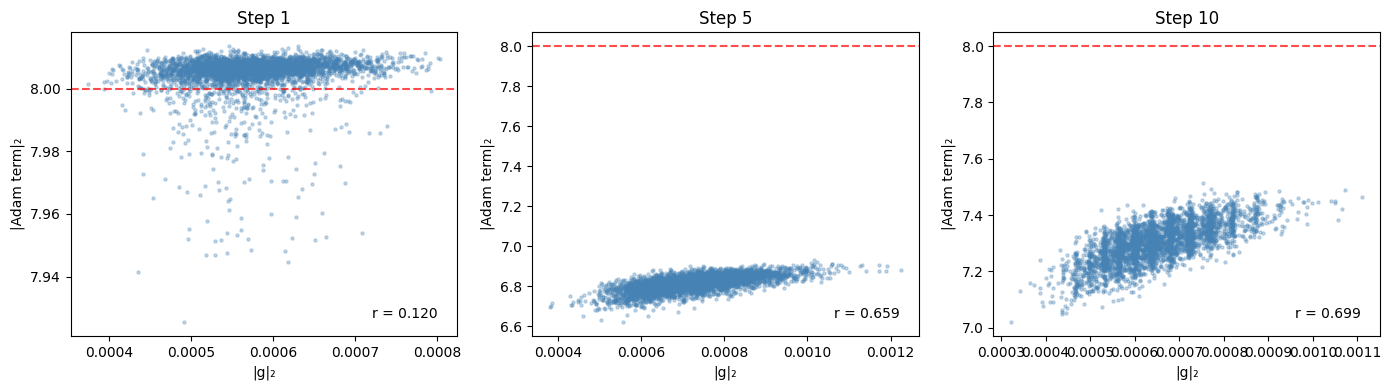

Saved: ../analysis/thrust_period_scatter.png


In [34]:
# Scatter plot: gradient norm vs adam norm at steps 1, 5, 10
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, step_idx in zip(axes, [0, 4, 9]):  # steps 1, 5, 10
    t = step_idx + 1
    ax.scatter(grad_norms[step_idx], adam_norms[step_idx], 
               alpha=0.3, s=5, c='steelblue')
    ax.axhline(y=np.sqrt(D), color='red', linestyle='--', alpha=0.7)
    ax.set_xlabel('|g|₂')
    ax.set_ylabel('|Adam term|₂')
    ax.set_title(f'Step {t}')
    
    # Add correlation
    corr = np.corrcoef(grad_norms[step_idx], adam_norms[step_idx])[0, 1]
    ax.text(0.95, 0.05, f'r = {corr:.3f}', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../analysis/thrust_period_scatter.png', dpi=200, bbox_inches='tight')
plt.show()

print("Saved: ../analysis/thrust_period_scatter.png")

In [36]:
# Extended view: steps 1-100 with spaghetti plot
# Each token gets a low-alpha line, density encodes distribution
# Mean line on top for orientation

N_STEPS = 100
steps_ext = range(1, N_STEPS + 1)

# Recompute for extended range
grad_norms_ext = []
adam_norms_ext = []
delta_W_norms_ext = []

for t in steps_ext:
    g_t = g[t-1].float()
    grad_norms_ext.append(torch.linalg.norm(g_t, dim=1))
    
    m_t = m[t].float()
    v_t = v[t].float()
    adam_term = compute_adam_term(m_t, v_t, t)
    adam_norms_ext.append(torch.linalg.norm(adam_term, dim=1))
    
    delta_W = W[t] - W[t-1]
    delta_W_norms_ext.append(torch.linalg.norm(delta_W, dim=1))

# Stack: [100, 3699]
grad_norms_ext = torch.stack(grad_norms_ext).numpy()
adam_norms_ext = torch.stack(adam_norms_ext).numpy()
delta_W_norms_ext = torch.stack(delta_W_norms_ext).numpy()

print(f"Extended data: {N_STEPS} steps, {grad_norms_ext.shape[1]} tokens")

Extended data: 100 steps, 3699 tokens


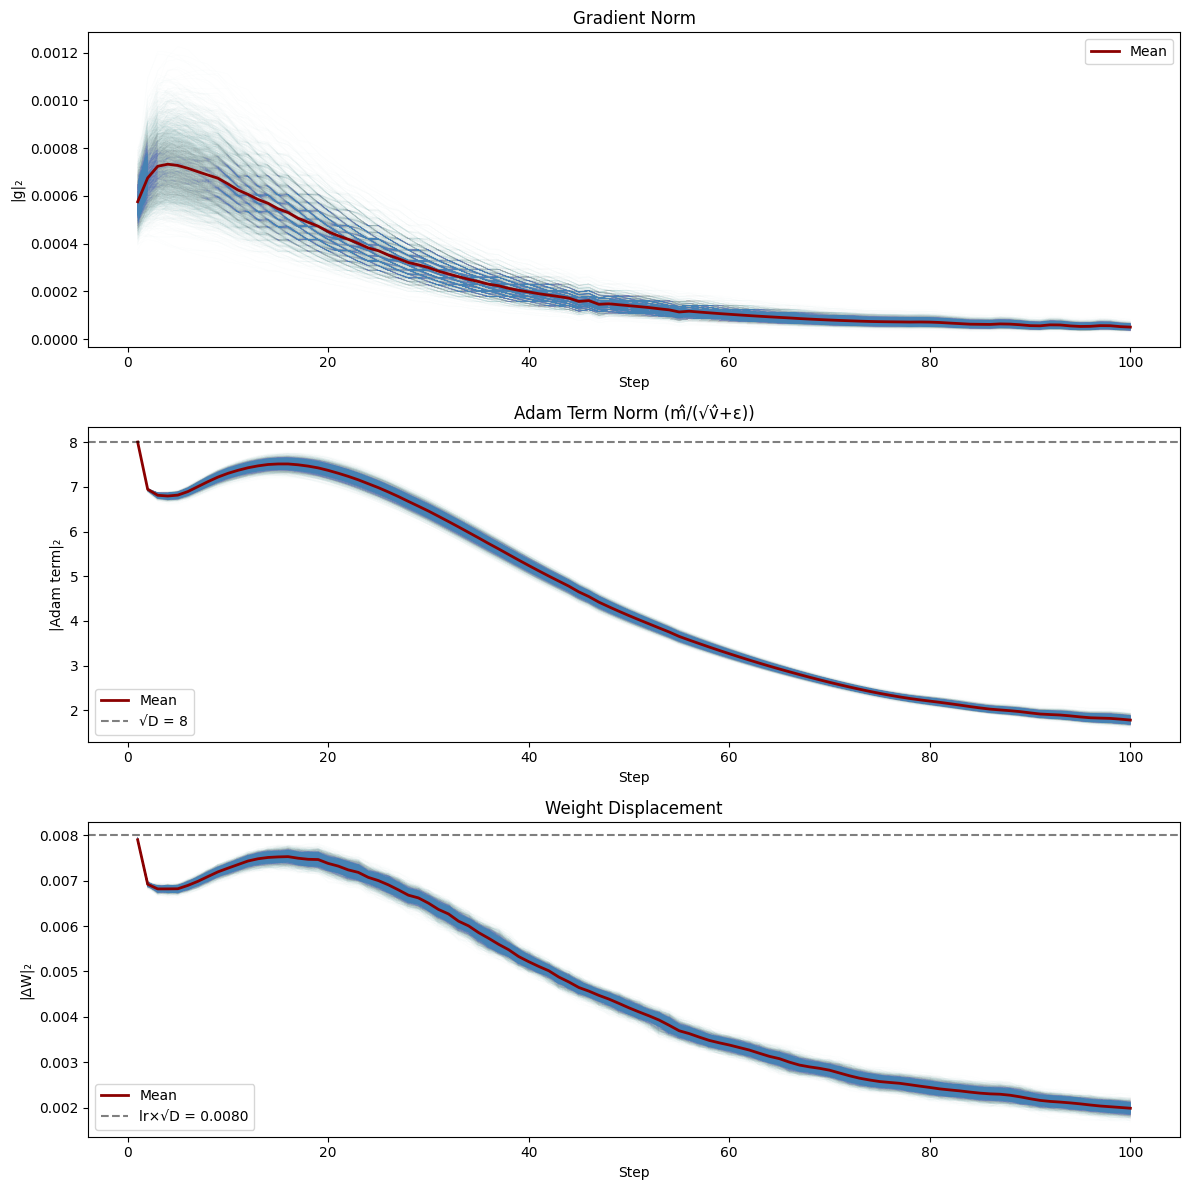

Saved: ../analysis/thrust_period_spaghetti.png


In [38]:
# Spaghetti plot: all tokens, low alpha, mean on top
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

x = np.array(list(steps_ext))
n_tokens = grad_norms_ext.shape[1]

# Plot all tokens - matplotlib can handle it
alpha = 0.01  # Low alpha so density = darkness

# Panel 1: Gradient norms
ax = axes[0]
for i in range(n_tokens):
    ax.plot(x, grad_norms_ext[:, i], color='steelblue', alpha=alpha, linewidth=0.5)
ax.plot(x, grad_norms_ext.mean(axis=1), color='darkred', linewidth=2, label='Mean')
ax.set_xlabel('Step')
ax.set_ylabel('|g|₂')
ax.set_title('Gradient Norm')
ax.legend()

# Panel 2: Adam term norms
ax = axes[1]
for i in range(n_tokens):
    ax.plot(x, adam_norms_ext[:, i], color='steelblue', alpha=alpha, linewidth=0.5)
ax.plot(x, adam_norms_ext.mean(axis=1), color='darkred', linewidth=2, label='Mean')
ax.axhline(y=np.sqrt(D), color='black', linestyle='--', alpha=0.5, label=f'√D = {np.sqrt(D):.0f}')
ax.set_xlabel('Step')
ax.set_ylabel('|Adam term|₂')
ax.set_title('Adam Term Norm (m̂/(√v̂+ε))')
ax.legend()

# Panel 3: Displacement norms
ax = axes[2]
for i in range(n_tokens):
    ax.plot(x, delta_W_norms_ext[:, i], color='steelblue', alpha=alpha, linewidth=0.5)
ax.plot(x, delta_W_norms_ext.mean(axis=1), color='darkred', linewidth=2, label='Mean')
ax.axhline(y=LR * np.sqrt(D), color='black', linestyle='--', alpha=0.5, label=f'lr×√D = {LR*np.sqrt(D):.4f}')
ax.set_xlabel('Step')
ax.set_ylabel('|ΔW|₂')
ax.set_title('Weight Displacement')
ax.legend()

plt.tight_layout()
plt.savefig('../analysis/thrust_period_spaghetti.png', dpi=200, bbox_inches='tight')
plt.show()

print("Saved: ../analysis/thrust_period_spaghetti.png")

## Gradient Quantization Cohort Test

**Hypothesis:** bfloat16 quantization in the forward pass creates discrete gradient "bins." 
Tokens landing in the same bin receive identical (or near-identical) gradient signals, 
causing them to move in lockstep.

**Test:** At step 20 (where stripes are visible), bin tokens by their quantized gradient,
then check whether within-bin displacement correlation exceeds between-bin correlation.

**Null hypothesis:** Gradient bins are meaningless—shuffled bin assignments should 
show the same correlation structure as real bins.

In [39]:
# Step 20: Extract gradients and displacements
STEP = 20

g_step = g[STEP - 1].float()  # [3699, 64] - gradient at step 20
delta_W_step = (W[STEP] - W[STEP - 1])  # [3699, 64] - displacement at step 20

print(f"Step {STEP}:")
print(f"  Gradient shape: {g_step.shape}")
print(f"  Displacement shape: {delta_W_step.shape}")

# How quantized are these gradients?
# Let's look at unique values per dimension
unique_counts = [len(torch.unique(g_step[:, d])) for d in range(64)]
print(f"\nUnique gradient values per dimension:")
print(f"  Min: {min(unique_counts)}, Max: {max(unique_counts)}, Mean: {np.mean(unique_counts):.1f}")

Step 20:
  Gradient shape: torch.Size([3699, 64])
  Displacement shape: torch.Size([3699, 64])

Unique gradient values per dimension:
  Min: 165, Max: 175, Mean: 168.8


Unique gradient norms: 2446 (out of 3699 tokens)


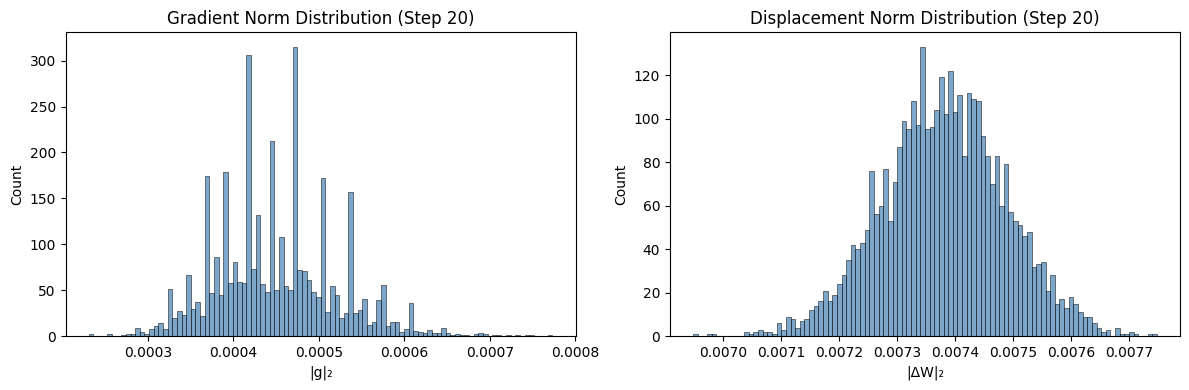

In [40]:
# Strategy: Bin tokens by their quantized gradient NORM
# (Full 64D binning would create too many sparse bins)
# 
# If gradient norms are quantized, tokens with identical norms 
# got gradients that are at least similar in magnitude

g_norms_step = torch.linalg.norm(g_step, dim=1).numpy()  # [3699]
delta_norms_step = torch.linalg.norm(delta_W_step, dim=1).numpy()  # [3699]

# How many unique gradient norms are there?
unique_g_norms = np.unique(g_norms_step)
print(f"Unique gradient norms: {len(unique_g_norms)} (out of {len(g_norms_step)} tokens)")

# Histogram of gradient norms - should show discrete bands if quantized
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(g_norms_step, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('|g|₂')
ax.set_ylabel('Count')
ax.set_title(f'Gradient Norm Distribution (Step {STEP})')

ax = axes[1]
ax.hist(delta_norms_step, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_xlabel('|ΔW|₂')
ax.set_ylabel('Count')
ax.set_title(f'Displacement Norm Distribution (Step {STEP})')

plt.tight_layout()
plt.show()

In [41]:
# Create gradient norm bins using quantiles (ensures roughly equal bin sizes)
N_BINS = 20
bin_edges = np.percentile(g_norms_step, np.linspace(0, 100, N_BINS + 1))
bin_assignments = np.digitize(g_norms_step, bin_edges[1:-1])  # 0 to N_BINS-1

print(f"Created {N_BINS} bins by gradient norm quantile")
print(f"Bin sizes: min={np.bincount(bin_assignments).min()}, max={np.bincount(bin_assignments).max()}")

# For each bin, compute the variance of displacement norms WITHIN the bin
within_bin_stds = []
within_bin_means = []
bin_sizes = []

for b in range(N_BINS):
    mask = bin_assignments == b
    if mask.sum() > 1:
        displacements_in_bin = delta_norms_step[mask]
        within_bin_stds.append(displacements_in_bin.std())
        within_bin_means.append(displacements_in_bin.mean())
        bin_sizes.append(mask.sum())

print(f"\nWithin-bin displacement std: mean={np.mean(within_bin_stds):.6f}")
print(f"Overall displacement std: {delta_norms_step.std():.6f}")
print(f"Ratio (within/overall): {np.mean(within_bin_stds) / delta_norms_step.std():.3f}")

Created 20 bins by gradient norm quantile
Bin sizes: min=180, max=191

Within-bin displacement std: mean=0.000094
Overall displacement std: 0.000107
Ratio (within/overall): 0.873


In [42]:
# Null hypothesis test: shuffle bin assignments and compare
np.random.seed(42)
N_SHUFFLES = 1000

shuffled_ratios = []
for _ in range(N_SHUFFLES):
    shuffled_bins = np.random.permutation(bin_assignments)
    shuffled_within_stds = []
    for b in range(N_BINS):
        mask = shuffled_bins == b
        if mask.sum() > 1:
            shuffled_within_stds.append(delta_norms_step[mask].std())
    shuffled_ratios.append(np.mean(shuffled_within_stds) / delta_norms_step.std())

shuffled_ratios = np.array(shuffled_ratios)
real_ratio = np.mean(within_bin_stds) / delta_norms_step.std()

# Where does the real ratio fall in the null distribution?
p_value = (shuffled_ratios <= real_ratio).mean()

print("=" * 60)
print("NULL HYPOTHESIS TEST: Gradient bins → Displacement coherence")
print("=" * 60)
print(f"\nReal within-bin/overall std ratio: {real_ratio:.4f}")
print(f"Shuffled ratio: mean={shuffled_ratios.mean():.4f}, std={shuffled_ratios.std():.4f}")
print(f"p-value (fraction of shuffles ≤ real): {p_value:.4f}")

if p_value < 0.05:
    print(f"\n🎯 SIGNIFICANT! Tokens in the same gradient bin have MORE similar")
    print(f"   displacements than expected by chance. The cohort effect is real.")
else:
    print(f"\n❌ Not significant. Gradient binning doesn't predict displacement similarity.")

NULL HYPOTHESIS TEST: Gradient bins → Displacement coherence

Real within-bin/overall std ratio: 0.8728
Shuffled ratio: mean=0.9961, std=0.0009
p-value (fraction of shuffles ≤ real): 0.0000

🎯 SIGNIFICANT! Tokens in the same gradient bin have MORE similar
   displacements than expected by chance. The cohort effect is real.


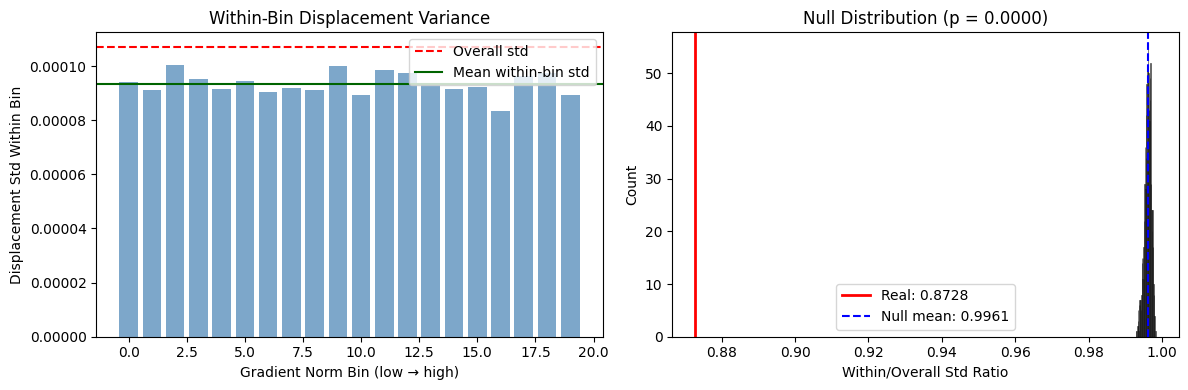

Saved: ../analysis/gradient_cohort_test.png


In [43]:
# Visualize: within-bin std vs bin index, with null distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: within-bin std for each bin
ax = axes[0]
ax.bar(range(len(within_bin_stds)), within_bin_stds, color='steelblue', alpha=0.7)
ax.axhline(y=delta_norms_step.std(), color='red', linestyle='--', label='Overall std')
ax.axhline(y=np.mean(within_bin_stds), color='darkgreen', linestyle='-', label='Mean within-bin std')
ax.set_xlabel('Gradient Norm Bin (low → high)')
ax.set_ylabel('Displacement Std Within Bin')
ax.set_title('Within-Bin Displacement Variance')
ax.legend()

# Right: null distribution with real value marked
ax = axes[1]
ax.hist(shuffled_ratios, bins=50, color='gray', alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(x=real_ratio, color='red', linewidth=2, label=f'Real: {real_ratio:.4f}')
ax.axvline(x=shuffled_ratios.mean(), color='blue', linestyle='--', label=f'Null mean: {shuffled_ratios.mean():.4f}')
ax.set_xlabel('Within/Overall Std Ratio')
ax.set_ylabel('Count')
ax.set_title(f'Null Distribution (p = {p_value:.4f})')
ax.legend()

plt.tight_layout()
plt.savefig('../analysis/gradient_cohort_test.png', dpi=200, bbox_inches='tight')
plt.show()

print("Saved: ../analysis/gradient_cohort_test.png")

In [44]:
# Stronger test: bin by the FULL gradient vector, not just norm
# Quantize gradients to bfloat16 and find tokens with identical quantized gradients

g_bf16 = g_step.to(torch.bfloat16)  # Quantize to bfloat16
g_bf16_flat = g_bf16.view(g_bf16.shape[0], -1)  # [3699, 64]

# Find unique quantized gradient vectors
unique_grads, inverse_indices = torch.unique(g_bf16_flat, dim=0, return_inverse=True)
n_unique = len(unique_grads)

print(f"Full gradient vector binning (bfloat16):")
print(f"  Unique gradient vectors: {n_unique} (out of {len(g_step)} tokens)")
print(f"  Compression ratio: {len(g_step) / n_unique:.1f}x")

# How big are the cohorts?
cohort_sizes = torch.bincount(inverse_indices).numpy()
print(f"\nCohort sizes:")
print(f"  Singletons (size 1): {(cohort_sizes == 1).sum()}")
print(f"  Size 2-5: {((cohort_sizes >= 2) & (cohort_sizes <= 5)).sum()}")
print(f"  Size 6-20: {((cohort_sizes > 5) & (cohort_sizes <= 20)).sum()}")
print(f"  Size > 20: {(cohort_sizes > 20).sum()}")
print(f"  Largest cohort: {cohort_sizes.max()} tokens")

Full gradient vector binning (bfloat16):
  Unique gradient vectors: 2446 (out of 3699 tokens)
  Compression ratio: 1.5x

Cohort sizes:
  Singletons (size 1): 1993
  Size 2-5: 381
  Size 6-20: 66
  Size > 20: 6
  Largest cohort: 41 tokens


In [45]:
# For cohorts with size > 1, check if their displacements are IDENTICAL
# (They should be, if they got the exact same quantized gradient and started
# from the same Adam state... but Adam state varies per token, so maybe not)

delta_W_np = delta_W_step.numpy()
inverse_np = inverse_indices.numpy()

# Find cohorts with multiple members
multi_member_cohorts = np.where(cohort_sizes > 1)[0]
print(f"Cohorts with >1 member: {len(multi_member_cohorts)}")

# For each multi-member cohort, compute displacement variance
cohort_displacement_stds = []
cohort_displacement_max_diff = []

for cohort_id in multi_member_cohorts:
    member_mask = inverse_np == cohort_id
    member_displacements = delta_W_np[member_mask]  # [n_members, 64]
    
    # Std across members for each dimension, then mean
    if len(member_displacements) > 1:
        std_per_dim = member_displacements.std(axis=0)
        cohort_displacement_stds.append(std_per_dim.mean())
        
        # Max difference between any two members
        max_diff = np.abs(member_displacements[:, None] - member_displacements[None, :]).max()
        cohort_displacement_max_diff.append(max_diff)

print(f"\nWithin-cohort displacement variation (tokens with IDENTICAL bfloat16 gradients):")
print(f"  Mean std across dimensions: {np.mean(cohort_displacement_stds):.8f}")
print(f"  Max std: {np.max(cohort_displacement_stds):.8f}")
print(f"  Mean max pairwise diff: {np.mean(cohort_displacement_max_diff):.8f}")
print(f"  Max max pairwise diff: {np.max(cohort_displacement_max_diff):.8f}")

# Compare to overall displacement std
print(f"\nOverall displacement std per dimension: {delta_W_np.std(axis=0).mean():.8f}")

Cohorts with >1 member: 453

Within-cohort displacement variation (tokens with IDENTICAL bfloat16 gradients):
  Mean std across dimensions: 0.00002465
  Max std: 0.00004110
  Mean max pairwise diff: 0.00018744
  Max max pairwise diff: 0.00024414

Overall displacement std per dimension: 0.00004131
